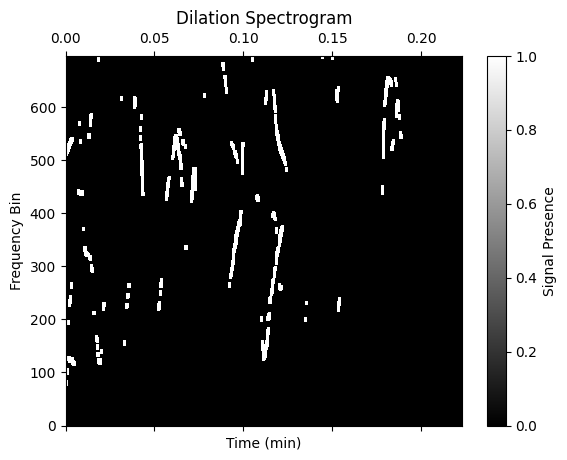

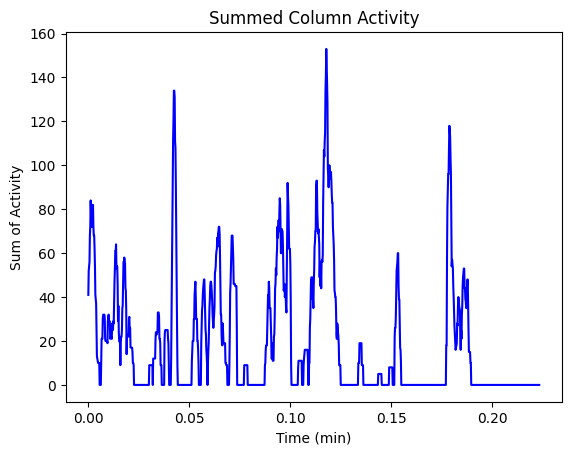

In [1]:
# LIBRARIES
#run 'pip install opencv-python-headless' in bash
import numpy as np
import librosa
import librosa.display
import cv2
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import soundfile as sf
from matplotlib.colors import ListedColormap

# IMPORT AUDIO
file_path = "Audios/Dolphin_Many_Short.wav"
y, sr = librosa.load(file_path, sr=None) # y is the whole signal
base_name = os.path.splitext(os.path.basename(file_path))[0]

# FUNCTIONS
def process_audio_chunk(y_chunk, sr, n_fft=2048, hop_length=512):
    D_chunk = librosa.amplitude_to_db(np.abs(librosa.stft(y_chunk, n_fft=n_fft, hop_length=hop_length)), ref=np.max)
    return D_chunk

def detect_dolphin_whistle(D_chunk, sr, n_fft, frequency_range=(5000, 20000), threshold=-50):
    # Focus on the specified frequency range
    freq_bin_indices = np.where((librosa.fft_frequencies(sr=sr, n_fft=n_fft) >= frequency_range[0]) &
                                (librosa.fft_frequencies(sr=sr, n_fft=n_fft) <= frequency_range[1]))[0]
    D_chunk_filtered = D_chunk[freq_bin_indices, :]

    _, binary_spectrogram = cv2.threshold(D_chunk_filtered, threshold, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_spectrogram.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        if len(contour) > 10:
            x, y, w, h = cv2.boundingRect(contour)
            aspect_ratio = float(h) / w
            if aspect_ratio > 1.3:
                return True
    return False

# Parameters
n_fft = 2048
hop_length = 512
frequency_range = (5000, 20000)
spike_threshold = -50

# Generate the spectrogram
D = process_audio_chunk(y, sr, n_fft=n_fft, hop_length=hop_length)

# Focus on the specified frequency range
freq_bin_indices = np.where(
    (librosa.fft_frequencies(sr=sr, n_fft=n_fft) >= frequency_range[0]) &
    (librosa.fft_frequencies(sr=sr, n_fft=n_fft) <= frequency_range[1])
)[0]
D_filtered = D[freq_bin_indices, :]

# Binarize the spectrogram
_, binary_spectrogram = cv2.threshold(D_filtered, spike_threshold, 255, cv2.THRESH_BINARY)

# Ensure binary_spectrogram is properly binarized and of the correct type
binary_spectrogram = np.where(binary_spectrogram > 0, 1, 0).astype(np.uint8)

# Perform dilation
kernel = np.ones((5, 5), np.uint8)
dilation = cv2.dilate(binary_spectrogram, kernel, iterations=2)

# Constants for plotting
duration_seconds = len(y) / sr  # Total duration of the audio in seconds
time_axis = np.linspace(0, duration_seconds / 60, binary_spectrogram.shape[1])  # Convert to minutes

# Plot the Dilation Spectrogram
plt.figure()
plt.matshow(
    dilation, fignum=0, aspect='auto', cmap='gray',
    extent=[time_axis[0], time_axis[-1], 0, dilation.shape[0]]
)
plt.title('Dilation Spectrogram')
plt.xlabel('Time (min)')
plt.ylabel('Frequency Bin')
plt.colorbar(label='Signal Presence')
plt.show()

# Calculate the sum of all columns
emg_sum = dilation.sum(axis=0)  # Sum along the rows for each column

# Convert time to minutes
time_axis = np.linspace(0, duration_seconds / 60, len(emg_sum))  # Duration in minutes

# Plot the summed activity
plt.figure()
plt.plot(time_axis, emg_sum, color='blue')  # Specify color if desired
plt.title('Summed Column Activity')
plt.xlabel('Time (min)')
plt.ylabel('Sum of Activity')
plt.show()